# Section 1

### Assignment

Complete the following problems. Use code cells to develop and run any Python code required and Markdown cells to respond to any auxilliary questions that ask you to interpret your results. The goal of this homework is to refresh / familiarize with basic data visualization.

1. Download the linked catalog [table](http://homepages.spa.umn.edu/~scarlata/IpacTableFromSource.tbl) and load the data it contains. To help you, a description of the catalog can be found in [this paper](https://arxiv.org/pdf/1008.2974v1.pdf). The repository for this section contains a file named `IpacTableFromSource.html`, which contains a description of the columns in the catalog.

2. Use the data in the table to make a plot like Figure 11 of [the  paper](https://arxiv.org/pdf/1008.2974v1.pdf). This figure shows a (z-K) versus (B-z) color-color diagram, for all objects identified in a specific region of the sky. The lines broadly separate galaxies at different redshifts and galaxies from stars. Stars are located below the lowest line in the plot. Get approximate values for the lines - they don't need to be exact. [_Hint: You will need to refresh the definition of AB magnitude. Plot only objects with a significant detection, i.e., with flux larger than 5 times its error._] Identify with a different symbols objects classified as stars by SEXTRACTOR.

3. Select those objects with colors consistent with those of stars (based on the position in the diagram), and make a plot of their size `A_IMAGE` (previously `AP_TOT`) versus the u-band total magnitude.

4. Do the same with galaxies. Describe the differences between the star and galaxy plots, and discuss the origin of these differences.

5. Divide the plot for the stars in bins of size. Choose the bin size so that each bin has the same number of sources. In each bin compute the average magnitude. Plot the average magnitude at the position of the center of the bin. AST5031 also do: Divide the plot for the stars in bins of size and u-band magnitude. Choose the sizes of the bin in x and y so that each bin has approximately the same number of sources. In each bin compute the average I-band magnitude. Plot at the position of the center of each bin a filled circle color coded according to the average I-band magnitude in that bin. Do you see any trend? 

## Model Solution

Start by importing the required modules.

In [1]:
import astropy as ap
import astropy.io.ascii as apascii
import astropy.table as aptable
import numpy as np
import matplotlib
import matplotlib.pyplot as mplplot

from IPython.display import HTML

%matplotlib inline

#### Question 1: _(1 marks)_
The linked table is in [IPAC Table format](https://irsa.ipac.caltech.edu/applications/DDGEN/Doc/ipac_tbl.html). The `astropy.io.ascii` module has built-in functionality that will automatically download and parse the table directly into an [`astropy.table.Table` data structure](http://docs.astropy.org/en/stable/table/). 

In [2]:
dataTableUrl = 'http://homepages.spa.umn.edu/~scarlata/IpacTableFromSource.tbl'
dataTable = apascii.read(dataTableUrl)

#### Question 2: _(4 marks)_
The data have been downloaded and are accessible by referencing the `dataTable` variable, but we need to examine the `IpacTableFromSource.html` file to understand what the various data columns contain. Jupyter Lab lets us view the HTML inline.

In [3]:
HTML('IpacTableFromSource.html')

Figure 11 in the paper plots (z-K) versus (B-z) where B, K and z are [**AB magnitudes**](https://en.wikipedia.org/wiki/AB_magnitude). We can see that the table does not contain any **magnitude** values but it does contain some flux values (`f_b`, `f_k`, `f_z`) and their errors (`e_b`, `e_k`, `e_z`), both in $\mu \mathrm{Jy}$ units. We need to convert the fluxes for the B, Z and k bands to magnitudes. The formula for the conversion is:
\begin{equation}
m_{AB} = -2.5\log_{10}\left(\frac{f}{\mathrm{Jy}}\right) + 8.9
\end{equation}
Let's define a function that will perform the conversion from $\mu\mathrm{Jy}$ to AB magnitude for us. We'll use the `numpy.ma` versions of the mathematical operators and functions so are function will work directly on arrays, [masked arrays](https://docs.scipy.org/doc/numpy-1.15.1/reference/maskedarray.html) and astropy table column data without having to write any loops.

In [4]:
def fluxMicroJyToMagAB(fluxMicroJy):
    return -2.5*np.ma.log10(fluxMicroJy/1e6) + 8.9

Now we can compute the two colours we need for our plot. Note that `astropy.table.Table` instances allow column lookup using the indexing operator (e.g.`tableInstance['column_name]`).

In [5]:
zMinusK = fluxMicroJyToMagAB(dataTable['f_z']) - fluxMicroJyToMagAB(dataTable['f_k'])
bMinusZ = fluxMicroJyToMagAB(dataTable['f_b']) - fluxMicroJyToMagAB(dataTable['f_z'])

The question instructs us to retain only objects that are detected at have fluxes at least 5 times larger than their errors in all bands. We'll write a selection expression that we can use to isolate the required elements of the colour arrays we computed. We can use the `&` operator to compute the element-wise boolean `and` operation for whole arrays. Note that the syntax when combining several sub-expressions with `&` requires important that each is enclosed in parentheses. Note that it's also possible to assign a boolean expression to a variable so that we can use it multiple times.

In [6]:
fiveSigmaSelection = (
    dataTable['f_z'] > 5*dataTable['e_z']) & (
    dataTable['f_b'] > 5*dataTable['e_b']) & (
    dataTable['f_k'] > 5*dataTable['e_k'])

We also need to identify which objects are stars. We can do this using the `class_star` column. Following the  link in the HTML table, we find an entry suggesting that `class_star` is a categorical variable with two possible values:

| Value      | Category |
| ---------- | ----------- |
| 0      | Galaxy       |
| 1   | Star        |
In fact, the documentation is wrong and `class_star` can take any value between zero and one, with values close to one indicating a high probability that the object is a star. To show this, let's plot the distribution of `class_star` and then write another expression that selects stars.

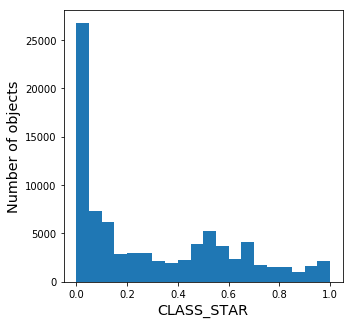

In [7]:
classStarFigure = mplplot.figure(figsize=(5,5))
classStarAxes = classStarFigure.add_subplot(1,1,1)
classStarAxes.hist(dataTable['class_star'], bins=20)
classStarAxes.set_xlabel('CLASS_STAR', fontsize='x-large')
classStarAxes.set_ylabel('Number of objects', fontsize='x-large')
starSExtractorSelection = dataTable['class_star'] > 0.95

Now we're ready to plot our data. We'll use the [`matplotlib.pyplot.scatter` function](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.scatter.html). Note that we make sure that the axes have labels and that their limits match those in the plot. We also add a legend to label the stars and galaxies. To figure includes several lines that separate various regions of the figure. The equation for the most important line, which separates nominal stars and galaxies is provided in the text of the paper:

\begin{equation}
(z−K) = 0.3(B−z)−0.5
\end{equation}

For the remaining lines we can we can examine the points where they intersect the graph axes. 

\begin{align}
(z−K) &= [(4.3 + 0.2)/(4.5 - 0)](B−z)−0.2 = (B−z)−0.2\\
(z−K) &= 2.5
\end{align}
We can us the handy [`lambda` syntax](https://www.w3schools.com/python/python_lambda.asp) to define short functions that compute these equations. Note that we use the [`numpy.ones_like()` function](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ones_like.html) to handle the constant-valued line.

In [8]:
# Define a dict so we can look up the lambda expressions by name
separators = {'sep1' : lambda bMinusZ : 0.3 * bMinusZ - 0.5, 
              'sep2' : lambda bMinusZ : bMinusZ - 0.2,
              'sep3' : lambda bMinusZ : 2.5*np.ones_like(bMinusZ)}

The caption of the figure in the paper also specifies that offsets have been added to the computed colours. We'll emulate these offsets.

In [9]:
# Define a dict so we can look up the offsets by name
offsets = {'bMinusZ': 0.56, 'zMinusK': -0.04}
# Apply offsets to colour arrays
bMinusZ = bMinusZ + offsets['bMinusZ']
zMinusK = zMinusK + offsets['zMinusK']

Finally we'll define a function in case we need to plot the data again. Spoiler alert!

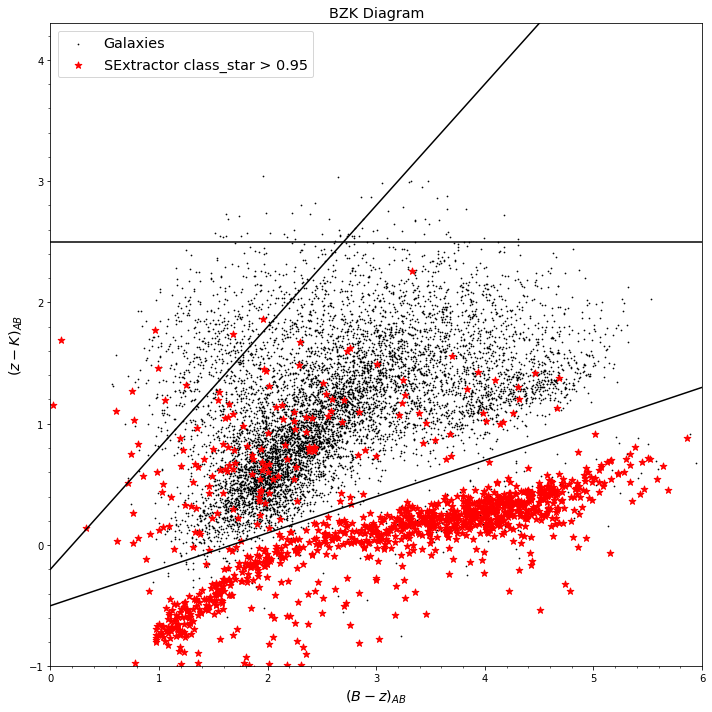

In [10]:
def plotColourColour(bMinusZ, zMinusK, galaxySelection, starSelection, separators):
    # Instantiate a figure and some axes to display the colour-colour plot
    colourColourFigure = mplplot.figure(figsize=(10,10))
    colourColourAxes = colourColourFigure.add_subplot(1,1,1)
    # Plot the galaxies (note the ~ negates a boolean array)
    colourColourAxes.scatter(bMinusZ[galaxySelection], 
                             zMinusK[galaxySelection], 
                             label='Galaxies', marker='.', s=2, c='k')
    # Plot the stars
    colourColourAxes.scatter(bMinusZ[starSelection], 
                             zMinusK[starSelection], 
                             label='SExtractor class_star > 0.95', marker='*', s=50, c='r')
    
    # Set axis limits
    colourColourAxes.set_xlim(0, 6)
    colourColourAxes.set_ylim(-1, 4.3)
    # Plot the separator lines using the lambda functions we defined
    bMinusZPoints = np.linspace(*colourColourAxes.get_xlim(), 100)
    for separator in separators.values():
        colourColourAxes.plot(bMinusZPoints, separator(bMinusZPoints),  c='k')
    # Add title and axis labels
    colourColourAxes.set_title('BZK Diagram', fontsize='x-large')
    colourColourAxes.set_xlabel('$(B-z)_{AB}$', fontsize='x-large')
    colourColourAxes.set_ylabel('$(z-K)_{AB}$', fontsize='x-large')
    # Add minor tick marks to axes
    colourColourAxes.minorticks_on()
    # Add a legend
    colourColourAxes.legend(fontsize='x-large')
    # Trigger automatic layout
    mplplot.tight_layout()
    # Returning the axes allows us to add extra elements or overplot more data later
    return colourColourAxes
    
colourColourAxes = plotColourColour(bMinusZ, zMinusK,
                                    galaxySelection = (fiveSigmaSelection & ~starSExtractorSelection),
                                    starSelection = (fiveSigmaSelection & starSExtractorSelection), 
                                    separators=separators)

#### Question 3: (_3 marks_)

To select stars based on their position in the diagram, we can use the separator line shown on the plot in the paper. We can use the the same lambda function to define a selection function.

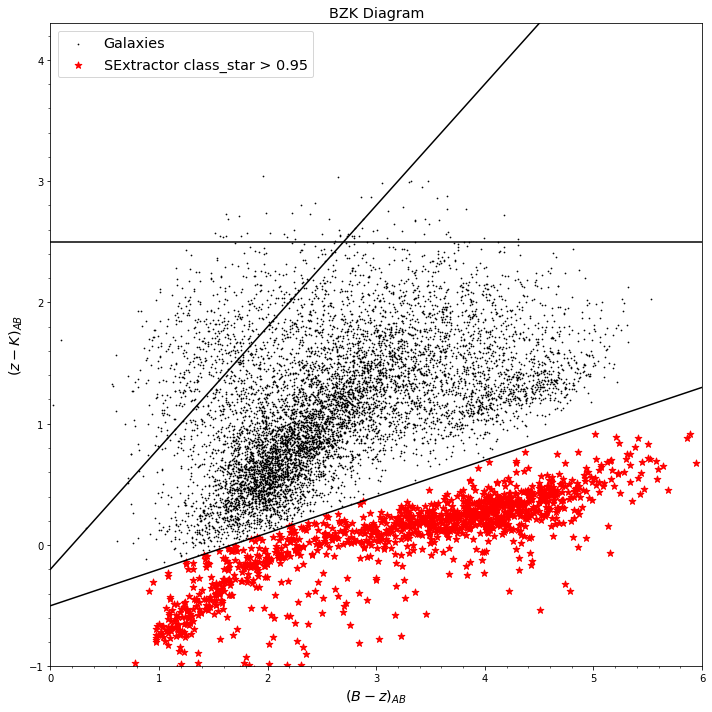

In [11]:
starColourSelection = zMinusK <= separators['sep1'](bMinusZ)
plotColourColour(bMinusZ, zMinusK,
                 galaxySelection = (fiveSigmaSelection & ~starColourSelection),
                 starSelection = (fiveSigmaSelection & starColourSelection), 
                 separators=separators)

Now let's actually answer the question! We need to plot `a_image` versus the U-band magntude for **stars**. Again, let's define a function to do this. 

Fainter objects have numerically larger magnitudes. To make plot more intuitive, we'll reverse the direction of the  U-magnitude axis so the faintest objects appear at the bottom. 

Since we're now plotting the **U band** magintude for each object, we'll update our data selections to exclude objects that are not detected at the $>5\sigma$ level in the U band.

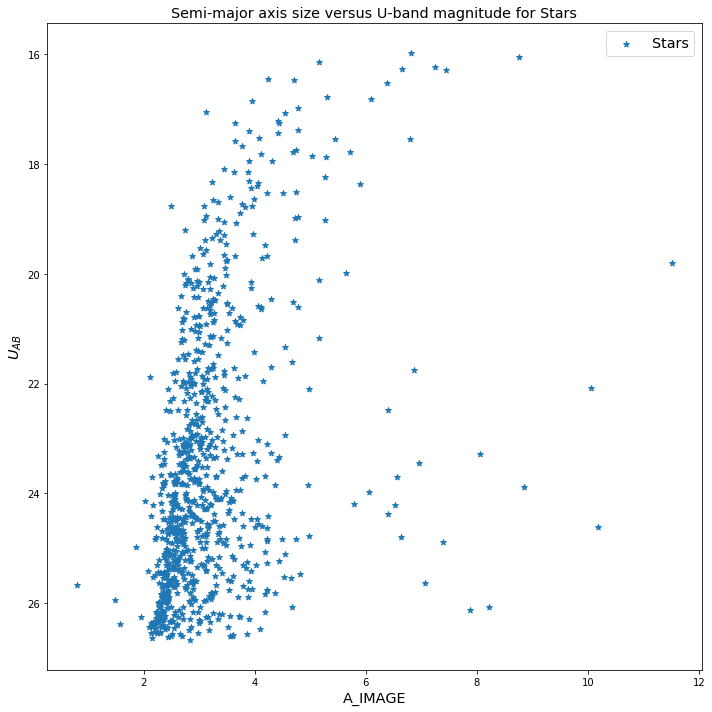

In [12]:
def plotSemiMajorVersusUMag(aImage, 
                            uBandMag, 
                            selection, 
                            title, 
                            marker='.', 
                            axes=None, 
                            colours=None, 
                            colourMap=None):
    # Instantiate a figure and some axes to display the colour-colour plot
    if axes is None:
        sizeMagFigure = mplplot.figure(figsize=(10,10))
        sizeMagAxes = sizeMagFigure.add_subplot(1,1,1)
    else:
        sizeMagFigure = axes.figure
        sizeMagAxes = axes
    # Plot the selected data
    sizeMagAxes.scatter(aImage[selection], 
                        uBandMag[selection], 
                        label=title, 
                        marker=marker, 
                        c=colours, 
                        cmap=colourMap)
    # reverse the U maginitude axis direction
    if axes is None:
        sizeMagAxes.set_ylim(*np.flipud(sizeMagAxes.get_ylim()))
    # Add title and axis labels
    sizeMagAxes.set_title('Semi-major axis size versus U-band magnitude for {category}'.format(category=title), fontsize='x-large')
    sizeMagAxes.set_xlabel('A_IMAGE', fontsize='x-large')
    sizeMagAxes.set_ylabel('$U_{AB}$', fontsize='x-large')
    # Add a legend
    sizeMagAxes.legend(fontsize='x-large')
    # Trigger automatic layout
    mplplot.tight_layout()
    return sizeMagAxes
    
uBandFiveSigmaSelection = (dataTable['f_u'] > 5*dataTable['e_u'])
dataSelection = (fiveSigmaSelection & uBandFiveSigmaSelection)
    
sizeMag = plotSemiMajorVersusUMag(aImage=dataTable['a_image'], 
                                  uBandMag=fluxMicroJyToMagAB(dataTable['f_u']), 
                                  selection=(dataSelection & starColourSelection), 
                                  title='Stars', marker='*')

#### Question 4: (_2 marks_)
We wrote a function to do the plotting, so we can just negate the selection for stars to get the galaxies.

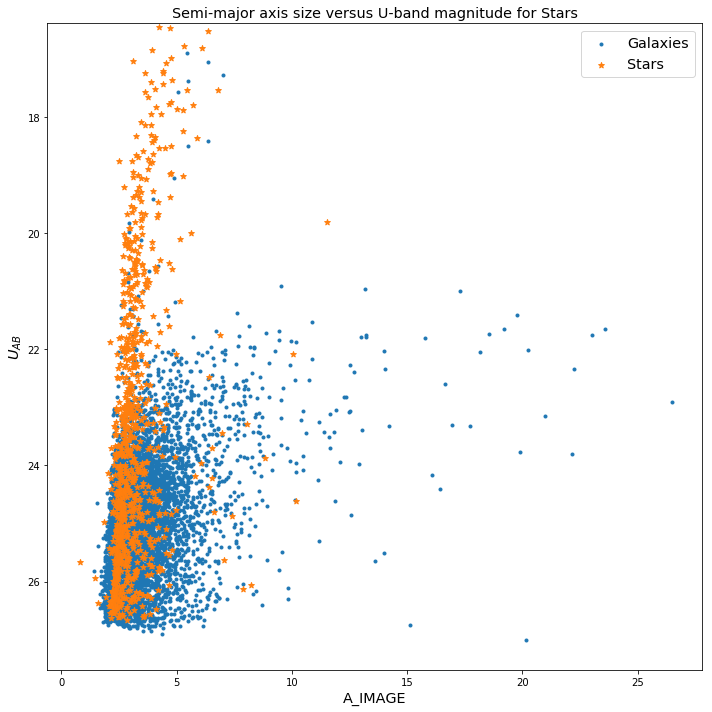

In [13]:
sizeMagAxes = plotSemiMajorVersusUMag(aImage=dataTable['a_image'], 
                                      uBandMag=fluxMicroJyToMagAB(dataTable['f_u']), 
                                      selection=(dataSelection & ~starColourSelection), 
                                      title='Galaxies')
sizeMagAxes = plotSemiMajorVersusUMag(aImage=dataTable['a_image'], 
                                      uBandMag=fluxMicroJyToMagAB(dataTable['f_u']), 
                                      selection=(dataSelection & starColourSelection), 
                                      title='Stars', axes=sizeMagAxes,  marker='*')

The question asks us to:
> Describe the differences between the star and galaxy plots, and discuss the origin of these differences.

We can use a _Markdown_ cell enter text instead of code. 

#### Some differences between the two distributions:
1. Very few star images have sizes larger than 5 pixels, while many galaxy images exceed this size. This is because all but the most nearby stars cannot be resolved and their aparent extension is simply caused by the finite point spread function of the telescope spreading their light over several pixels. Conversely, galaxies are much larger structure that contain many millions or even billions of stars and can be resolved into images that are larger than the telescope's point spread function.
2. Very few galaxies have U-band magnitudes smaller than $\sim 4$, while many stars are significantly brighter. This is because individual stars lie much closer than galaxies. Even though the total light output of galaxies is many millions or billions of times greater than that of a single star, the proximity of individual nearby stars can make them appear brighter than even the most luminous galaxy.

#### Question 5: _(4 marks for part 1. 6 marks for part 2)_
Part one of the question asks us to group the image size values for **stars** into bins of equal population. An easy way to do this is to compute evenly spaced **percentiles** of the distribution of image sizes. We can use the [`numpy.percentile`](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.percentile.html) function to do this. 

Let's define 15 bins with equal population. First we'll define the percentiles to compute. these will be 16 evenly spaced values between 0 and 100.

In [14]:
numBins = 15
targetPercentiles = np.linspace(0, 100, numBins+1)
print(targetPercentiles)

[  0.           6.66666667  13.33333333  20.          26.66666667
  33.33333333  40.          46.66666667  53.33333333  60.
  66.66666667  73.33333333  80.          86.66666667  93.33333333
 100.        ]


Now compute the values of `a_image` for the star selection that correspond to these percentiles. We'll use the [`numpy.nanpercentile`](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.nanpercentile.html) function to automatically ignore any not-a-number values.

From now on, we're only dealing with stars, so let's combine the colour-based star selection permanently with signal-to-noise based selections.

In [15]:
dataSelection &= starColourSelection

binBoundaries = np.nanpercentile(a=dataTable['a_image'][dataSelection], 
                                 q=targetPercentiles)
print(binBoundaries)

[ 0.801   2.303   2.402   2.4922  2.5764  2.69    2.7718  2.876   2.982
  3.1     3.203   3.3578  3.6088  3.9404  4.547  11.51  ]


We can use the [`numpy.digitize`](https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.digitize.html) function to create an array of bin indices for each of our selected stars.

Before continuing, we need to manipulate the output of the `digitize` function in three ways:
1. `digitize` will assign all not-a-number (`NaN`) valued data to the highest bin. This is not problematic for plotting or computation, since `NaN` values are ignored automatically by these operations. However it can be confusing when attempting to count the number of entries in each bin.
This is because the bin boundary definition using `nanpercentile` tries to define bins with equal numbers of non-`NaN` values, but these bins may also contain some `NaN` values. To handle this potential issue, we'll flag `NaN` values with an index value that can be easily identified and filtered later. A negative value like `-99` is a sensible choice.
2. `digitize` returns bin numbers starting from 1. We'd prefer our bin numbers to be zero indexed, so we'll subtract 1 from all the indices.
3. `digitize` treats bins as semi-open. By default the lower bound is open. This means that if a value falls exactly on the upper bin boundary, a new bin will be defined. The outcome in our case is that digitize will define `numBins + 1` bins with the last bin containing a single entry which is corresponds to the highest size value in our dataset. We can use the `numpy.clip` function to re-assign any bin labels larger than `numBins - 1` (remember our labels start from 0 now!) to be equal to `numBins - 1`.

We'll define a funtion so we can reuse the code later.

In [16]:
def computeBinIndices(selectedData, binBoundaries, nanIndexValue=-99, verbose=True):
    binIndices = np.digitize(x=selectedData, 
                             bins=binBoundaries)
    # Flag NaN values using an index that we can use to filter on later.
    binIndices[np.isnan(selectedData)] = nanIndexValue
    # Make bin numbers zero-indexed
    binIndices = binIndices - 1
    # Generate a sorted list of unique bin indices that will help us appropriately
    # apply the numpy.clip function
    sortedUniqueBinIndices = np.sort(np.unique(binIndices))
    if verbose:
        # Verify that the highest bin only contains one entry and that this entry corresponds to the largest
        # a_image value in our dataset.
        print('Contents of highest index bin:', 
              selectedData[binIndices == sortedUniqueBinIndices[-1]], 
              sep='\n', end='\n')
    # Clip the bin indices array to relabel the datum in the singly occupied bin.
    binIndices = np.clip(binIndices, sortedUniqueBinIndices[0], sortedUniqueBinIndices[-2])
    if verbose:
        # Verify that we have generated the required number of bins and that the
        # labels are zero-indexed.
        print('Unique bin indices:', 
              np.unique(binIndices), 
              sep='\n', end='\n')

    return binIndices

Now we can finally compute the average values of the U-band magniude in each bin. We'll use the [`numpy.mean`](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.mean.html) function within a Python [list comprehension](https://www.pythonforbeginners.com/basics/list-comprehensions-in-python) expression to do this. For clarity, the list comprehension is equivalent to:
```python
# Initialize an empty list of size bin means
meanMagnitudes = []
# Get a sorted list of unique bin indices
sortedUniqueBinIndices = np.sort(np.unique(binIndices))
# Loop over bin indices
for binIndex in sortedUniqueBinIndices:
    # Find all objects that belong in this bin
    binSelectionExpression = binIndices == binIndex
    binEntries = selectedData[binSelectionExpression]
    # Compute the mean of those objects' sizes
    binMean = np.mean(binEntries)
    meanMagnitudes.append(binMean)
```
Note that we need to recompute `sortedUniqueBinIndices` since we redefined `binIndices`.

In [17]:
uBandMag = fluxMicroJyToMagAB(dataTable['f_u'])
selectedUMagData = uBandMag[dataSelection]
selectedAImageData = dataTable['a_image'][dataSelection]

binIndices = computeBinIndices(selectedAImageData, binBoundaries)
# Use list comprehension
meanMagnitudes = np.array([np.mean(selectedUMagData[binIndices == binIndex]) for binIndex in np.sort(np.unique(binIndices))])

Contents of highest index bin:
a_image
  pix  
-------
  11.51
Unique bin indices:
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]


Now we can plot these mean magnitude values at the `a_image` bin centres. Let's overplot out mean values on the original data. For clarity, we'll also add a label to the plot legend.

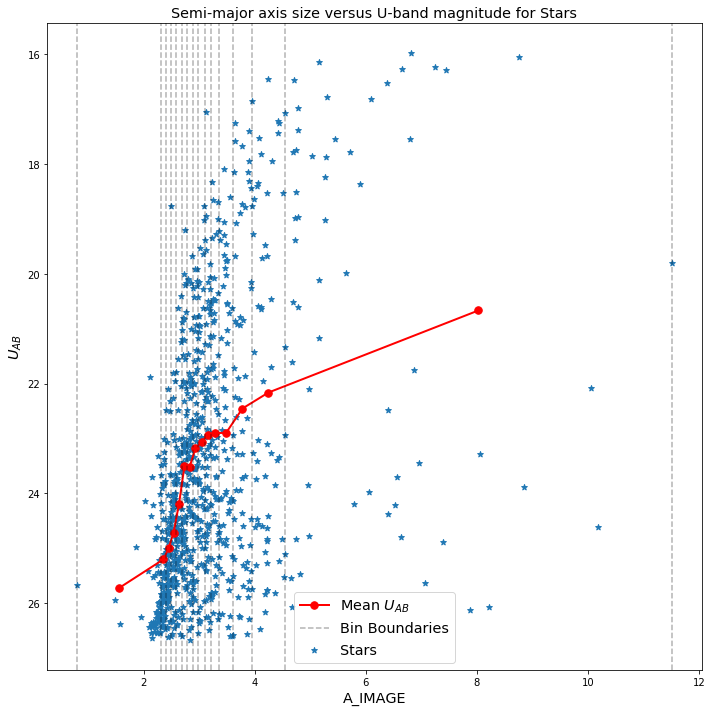

In [18]:
sizeMagAxes = plotSemiMajorVersusUMag(aImage=dataTable['a_image'], 
                                      uBandMag=uBandMag, 
                                      selection=dataSelection, 
                                      title='Stars',  marker='*')

sizeMagAxes.plot(0.5*(binBoundaries[1:] + binBoundaries[:-1]), meanMagnitudes, marker='.', ms=15, c='r', lw=2, label='Mean $U_{AB}$')

for counter, boundary in enumerate(binBoundaries):
    sizeMagAxes.axvline(boundary, ls='--', c='k', alpha=0.3, 
                        label = 'Bin Boundaries' if counter == 0 else None)    

sizeMagAxes.legend(fontsize='x-large')

The second part (for AST5031) requires definition of **approximately** equally populated bins in **two** dimensions. The trick here is to first make equal population bins in one axis, then for split the data in each bin into equally populated bins along the other axis.

We'll define a function that computes percentile based bins as above.

In [19]:
def percentileBins(data, numBins, verbose=False):
    targetPercentiles = np.linspace(0, 100, numBins+1)
    binBoundaries = np.nanpercentile(a=data, 
                                     q=targetPercentiles)
    if verbose:
        print('Bin boundaries:', binBoundaries, sep='\n')
    return binBoundaries

Since we'll need to compute the average **I-band** magintude in each bin, we'll update our data selections to exclude objects that are not detected at the $>5\sigma$ level in the I band.

In [20]:
iBandFiveSigmaSelection = (dataTable['f_i'] > 5*dataTable['e_i'])
dataSelection &= iBandFiveSigmaSelection

selectedUMagData = uBandMag[dataSelection]
selectedAImageData = dataTable['a_image'][dataSelection]
selectedIMagData = fluxMicroJyToMagAB(dataTable['f_i'])[dataSelection]

Let's define 10 percentile-based bins along the $U_{AB}$ axis. Note that the `selectedUMagData` variable actually refers to an `astropy.table.column.MaskedColumn`. We use the `filled` method to replace any masked values with `numpy.nan` so that the `numpy.nanpercentile` function will ignore the masked values.

The type of selectedUMagData is <class 'astropy.table.column.MaskedColumn'>
Bin boundaries:
[15.98026145 19.82190317 21.39086407 22.65868523 23.4333651  24.10886832
 24.62725128 25.13272429 25.63554924 26.15685983 26.66976349]
(10,)


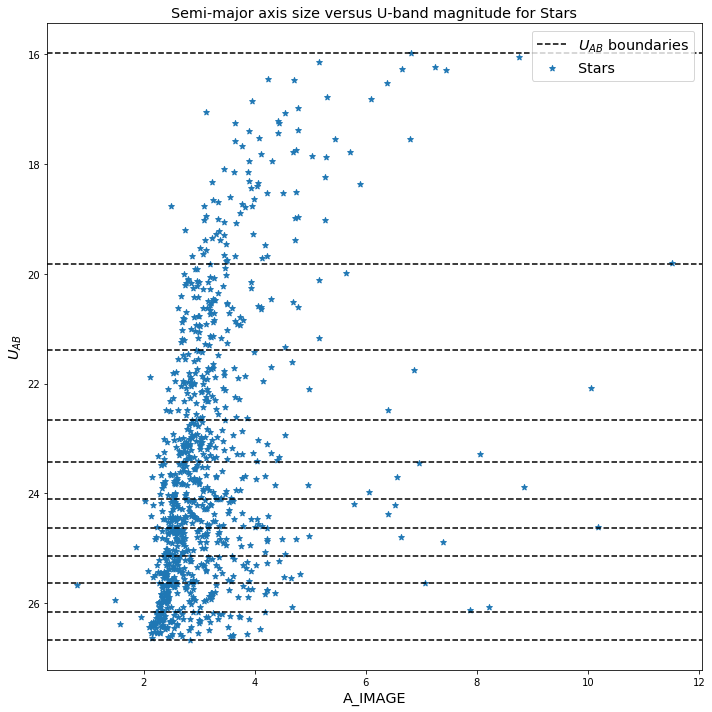

In [21]:
print('The type of selectedUMagData is', type(selectedUMagData))
uMagBinBoundaries = percentileBins(selectedUMagData.filled(np.nan), 10, verbose=True)
uMagBinCentres = 0.5*(uMagBinBoundaries[1:] + uMagBinBoundaries[:-1])

binningAxes = plotSemiMajorVersusUMag(aImage=dataTable['a_image'], 
                                      uBandMag=uBandMag, 
                                      selection=dataSelection, 
                                      title='Stars',  marker='*')

for counter, binBoundary in enumerate(uMagBinBoundaries):
    binningAxes.axhline(y=binBoundary, c='k', ls='--', label='$U_{AB}$ boundaries' if counter == 0 else None)
    
binningAxes.legend(fontsize='x-large')
print(uMagBinCentres.shape)

Now for each bin in $U_{AB}$, divide the corresponding entries into percetile based bins.

We'll also make a plot to check that our binning algorithm is working.

Contents of highest index bin:
      f_u       
----------------
26.6697634932738
Unique bin indices:
[0 1 2 3 4 5 6 7 8 9]


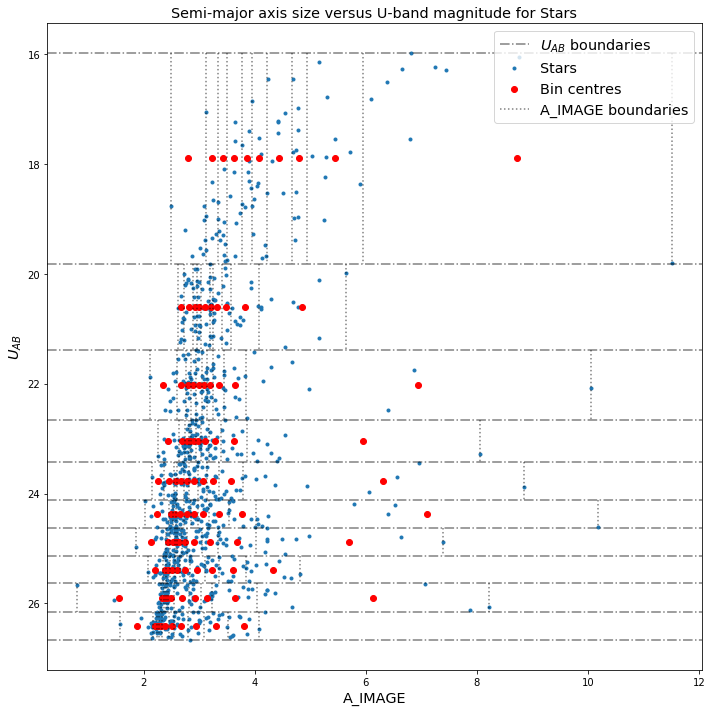

In [22]:
aImageBinBoundaries = []
aImageBinIndices = []
aImageBinCentres = []
uMagBinIndices = computeBinIndices(selectedUMagData.filled(np.nan), uMagBinBoundaries, verbose=True)

validUniqueUMagBinIndices = np.sort(np.unique(uMagBinIndices[uMagBinIndices >= 0]))

# Loop over bins in U-band magnitude
for uMagBinIndex in validUniqueUMagBinIndices:
    aImageData = selectedAImageData[uMagBinIndices==uMagBinIndex]
    aImageBinBoundaries.append(percentileBins(aImageData, 10))
    aImageBinCentres.append(0.5 * (aImageBinBoundaries[-1][1:] + aImageBinBoundaries[-1][:-1]))
    aImageBinIndices.append(computeBinIndices(aImageData, aImageBinBoundaries[-1], verbose=False))
    
binningAxes = plotSemiMajorVersusUMag(aImage=dataTable['a_image'], 
                                      uBandMag=uBandMag, 
                                      selection=dataSelection, 
                                      title='Stars',  marker='.')

# Now plot the bin boundaries and centres
for counter, uMagBinBoundary in enumerate(uMagBinBoundaries):
    # Plot the U band magnitude bin boundaries
    binningAxes.axhline(y=uMagBinBoundary, c='k', ls='-.', alpha=0.5,
                        label='$U_{AB}$ boundaries' if counter == 0 else None)
    if counter < len(aImageBinCentres[-1]):
        binningAxes.scatter(aImageBinCentres[counter],
                            np.repeat(uMagBinCentres[counter], 
                                      aImageBinCentres[counter].size),
                            marker='o', 
                            c='r', 
                            label='Bin centres' if counter == 0 else None)
        binningAxes.vlines(aImageBinBoundaries[counter], 
                           ymin=uMagBinBoundary, 
                           ymax=uMagBinBoundaries[counter+1], 
                           color='k', 
                           alpha=0.5,
                           linestyles='dotted',
                           label='A_IMAGE boundaries' if counter == 0 else None)
        
binningAxes.legend(fontsize='x-large')

Now that our bins are defined we can compute the mean value of the I-band magnitude in each bin and plot an appropriately sized marker at each bin centre. 

While we're computing the mean, we'll also check that we really did get approximately equal numbers of objects in each bin.

In [23]:
binPopulationSizes = []
meanIBandMags = []
for uMagBinIndex in validUniqueUMagBinIndices:
    uMagBinIBandMag = selectedIMagData[uMagBinIndices == uMagBinIndex]
    for aImageBinIndex in np.sort(np.unique(aImageBinIndices[uMagBinIndex])):
        aImageBinIBandMag = uMagBinIBandMag[aImageBinIndices[uMagBinIndex] == aImageBinIndex]
        meanIBandMags.append(np.mean(aImageBinIBandMag))
        binPopulationSizes.append(aImageBinIBandMag.size)
        
print('Unique bin population sizes: ', np.unique(binPopulationSizes))

Unique bin population sizes:  [ 7  8  9 10]


Now make the required plot with markers at the bin centres, colour-coded by mean I-band magnitude.

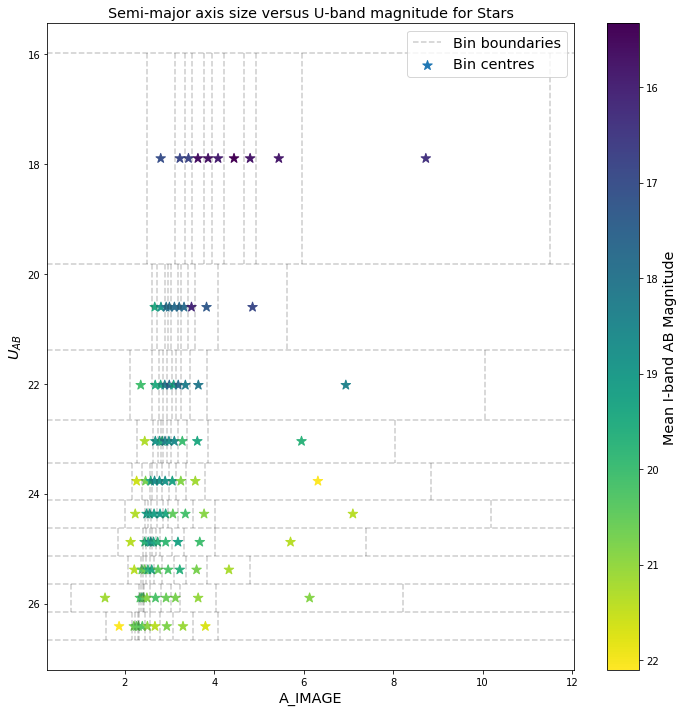

In [24]:
sizeMagFigure = mplplot.figure(figsize=(10,10))
sizeMagAxes = sizeMagFigure.add_subplot(1,1,1)
    
# Faintly plot the bin boundaries
for counter, uMagBinBoundary in enumerate(uMagBinBoundaries):
    sizeMagAxes.axhline(y=uMagBinBoundary, c='k', ls='--', alpha=0.2, 
                        label='Bin boundaries' if counter == 0 else None)
    if counter < len(aImageBinBoundaries):
        sizeMagAxes.vlines(aImageBinBoundaries[counter], 
                           ymin=uMagBinBoundary, 
                           ymax=uMagBinBoundaries[counter+1], 
                           color='k', alpha=0.2, linestyles='--')
    
# Plot the selected data
sizeMagScatterPlot = sizeMagAxes.scatter(np.array(aImageBinCentres).flatten(), 
                                         np.repeat(uMagBinCentres, len(aImageBinCentres[0])), 
                                         c=np.array(meanIBandMags).flatten(), 
                                         cmap='viridis', 
                                         label='Bin centres', 
                                         marker='*', 
                                         s=100)

iBandMagColourBar = mplplot.colorbar(sizeMagScatterPlot)

# reverse the U maginitude axis direction
sizeMagAxes.set_ylim(*np.flipud(sizeMagAxes.get_ylim()))
# Add title and axis labels
sizeMagAxes.set_title('Semi-major axis size versus U-band magnitude for Stars', fontsize='x-large')
sizeMagAxes.set_xlabel('A_IMAGE', fontsize='x-large')
sizeMagAxes.set_ylabel('$U_{AB}$', fontsize='x-large')
# Invert the colour bar axis so "higher" -> brighter"  
iBandMagColourBar.ax.invert_yaxis()
iBandMagColourBar.set_label('Mean I-band AB Magnitude', fontsize='x-large')
# Add a legend
sizeMagAxes.legend(fontsize='x-large')

# Trigger automatic layout
mplplot.tight_layout()

#### Some observations
Stars that appear brighter in the U band are generally also brighter in the I band. At fixed U-band magnitude, stars with small image sizes are typically faint in the I band.